# IMDB 리뷰 데이터셋

- 유명한 인터넷 영화 데이터베이스인 imdb.com 에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 말뭉치

## 자연어 처리(natural language processing, NLP)

- 컴퓨터를 사용해 인간의 언어를 처리하는 분야
- 세부 분야
    - 음성 인식
    - 기계 번역
    - 감성 분석
    
- 자연어 처리 분야에서는 훈련 데이터를 말뭉치(corpus)라고 부름

## 임베딩

- 사람이 쓰는 자연어를 기계가 이해할 수 있는 숫자의 나열인 벡터로 바꾼 결과 혹은 그 과정 전체
- 컴퓨터에서 처리하는 모든 것은 숫자로 이루어진 데이터
    - 따라서 텍스트 그 자체를 신경망에 전달하지 않음
    - 합성곱 신경망에서 이미지를 다룰 때는 이미지가 정수 픽셀값으로 이루어져 있어서 특별히 변환을 하지 않음
    
- 텍스트 임베딩의 가장 쉬운 방법은 데이터에 등장하는 단어마다 고유한 정수를 부여하는 것
    - 예)
        - he : 10
        - follow : 11
        - the : 12
        - cat : 13
    - 단어에 매핑되는 정수는 단어의 의미나 크기와 관련이 없음
        - He를 10으로 매핑하고 cat을 13에 매핑하더라도 cat이 he보다 좋거나 크다는 뜻이 아님
    - 정수 중 몇 가지는 특정한 용도로 예약되어 있는 경우가 많음
        - 예) 0 : 패딩, 1 : 문장의 시작 SOS(start of siquence), 2 : 어휘 사전에 없는 토큰
            - 어휘 사전 : 훈련 세트에서 고유한 단어를 뽑아 만든 목록
            
- 일반적으로 영어 문장은 모두 소문자로 바꾸고 구둣점을 삭제한 다음 공백을 기준으로 분리
    - 이렇게 분리된 단어를 토큰(token)이라고 부름
        - 하나의 샘플은 여러 개의 토큰으로 이루어져 있고 이 때 하나의 토큰이 하나의 타임스텝에 해당
        
    - 영어 말뭉치에서 토큰은 단어와 같이 취급하는 경우가 많음
        - 한국어는 조사가 발달되어 있어 공백으로 나누는 것만으로는 부족함
            - 일반적으로 한글은 형태소 분석을 통해 토큰을 분리

# 원핫 인코딩을 활용한 RNN 텍스트 분류

## 데이터 준비

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# num_words : 단어 빈도가 많은 순서로 num_words 만큼 보존
# 전체 데이터셋에서 가장 자주 등장하는 단어 500개만 사용
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 500)

In [3]:
# 리뷰의 길이 출력
len(x_train[0]), len(x_train[1])

(218, 189)

- 각각 25000 개의 샘플로 이루어져 있음
- 텍스트 길이가 제각각임
    - 고정 크기의 2차원 배열에 담는 것 보다 리뷰마다 별도의 파이썬 리스트로 담아야 메모리를 효율적으로 사용할 수 있음

In [4]:
# 첫 번째 리뷰 출력
print(x_train[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [5]:
# 타깃 데이터
# 0 : 부정, 1 : 긍정
print(y_train[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 12)

### 각 리뷰의 길이 확인

- 각 리뷰의 길이를 넘파이 배열로 담아 평균 리뷰 길이, 길이 최솟값, 길이 최댓값을 확인

In [7]:
lengths = np.array([len(x) for x in x_train])

In [8]:
# 길이 평균값과 중간값
print(np.mean(lengths), np.median(lengths), np.min(lengths), np.max(lengths))

238.90085 179.0 11 2494


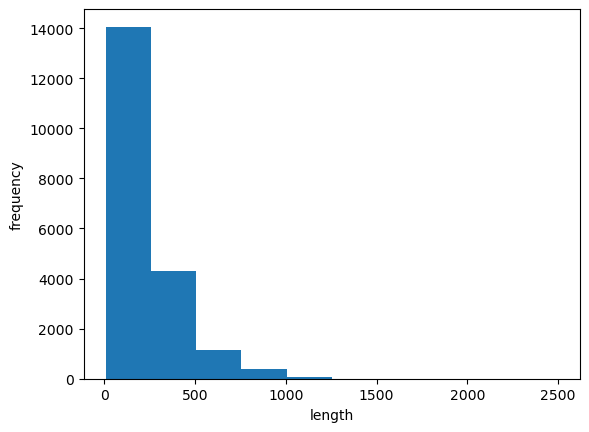

In [9]:
plt.figure()

plt.hist(lengths)

plt.xlabel("length")
plt.ylabel("frequency")
plt.show()

- 평균이 중간값보다 높은 이유는 아주 큰 데이터가 있기 때문
- 대부분의 리뷰는 짧기 때문에 이번 예제에서는 리뷰의 길이를 100에 맞춰서 사용
    - 100보다 짧은 리뷰는 길이를 100에 맞추기 위해 패딩이 필요
        - 패딩을 나타내는 토큰으로는 0을 사용

In [10]:
# x_train의 길이를 100으로 맞추기
train_seq = pad_sequences(x_train, maxlen = 100)

- maxlen 에 원하는 길이를 지정하면 그것보다 긴 경우는 잘라내고 짧은 경우는 0으로 패딩

In [11]:
# train_seq 크기 확인
print(train_seq.shape)

(20000, 100)


In [12]:
print(train_seq[0])

[337  13   2  25   8  24  67  14  20  13   2  13   2  45   2   8  67 142
 318  30   2  17 141   2   2 474   2  13 100   2   2   2  11  27   2 137
   4  20  16 395  48  25  26  24   2  19   2 113   5   2  81  24 193 233
  11  14  20  17 112   2   7   2  10  10  13   2 135 195  78 183  44  14
  20  48   2  71   2   5 219  14  20  29  62   2 309  95 174 279   2  30
   2   8  48  29   2  14  20  71   8   2]


In [13]:
print(x_train[0])

[1, 13, 2, 32, 4, 96, 143, 14, 20, 86, 7, 32, 4, 2, 114, 47, 117, 8, 81, 19, 2, 205, 65, 363, 47, 2, 8, 2, 6, 243, 7, 212, 2, 2, 20, 2, 2, 2, 2, 10, 10, 81, 24, 193, 233, 44, 14, 20, 8, 30, 2, 4, 403, 2, 11, 4, 425, 5, 2, 7, 27, 2, 9, 43, 343, 17, 2, 18, 6, 364, 352, 2, 20, 6, 2, 2, 8, 2, 6, 171, 2, 39, 4, 2, 2, 5, 27, 337, 2, 2, 336, 69, 196, 237, 77, 351, 11, 2, 4, 85, 2, 105, 26, 2, 2, 7, 14, 47, 233, 8, 81, 19, 2, 113, 42, 341, 10, 10, 48, 25, 26, 6, 2, 337, 13, 2, 25, 8, 24, 67, 14, 20, 13, 2, 13, 2, 45, 2, 8, 67, 142, 318, 30, 2, 17, 141, 2, 2, 474, 2, 13, 100, 2, 2, 2, 11, 27, 2, 137, 4, 20, 16, 395, 48, 25, 26, 24, 2, 19, 2, 113, 5, 2, 81, 24, 193, 233, 11, 14, 20, 17, 112, 2, 7, 2, 10, 10, 13, 2, 135, 195, 78, 183, 44, 14, 20, 48, 2, 71, 2, 5, 219, 14, 20, 29, 62, 2, 309, 95, 174, 279, 2, 30, 2, 8, 48, 29, 2, 14, 20, 71, 8, 2]


- pad_sequences() 함수는 기본적으로 maxlen 보다 긴 시퀀스의 앞부분을 잘라냄
    - 일반적으로 시퀀스의 뒷부분의 정보가 더 유용하기 때문에
        - 리뷰 끝에 결정적인 소감을 말할 가능성이 높음
    - 시퀀스의 뒷부분을 잘라내고 싶다면
        - truncating 매개변수 값을 "post"로 변경
            - 기본값은 "pre"

In [14]:
train_seq[3]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   1,   4,  64, 282,   8,  67,  14,  20,   9,  18,   6,
         2, 239,  34,   2,   2,   2,  37,   9,   2,  11,   4,  20,   2,
         4,  20,  17,   2,   2,   2,   9,  52,  99,   2,  45,   2,   2,
         4,   2, 152,  60,   2,  89, 127,  29,   2,   2,   4,   2,  23,
         4,   2,   2,   8,   2,  46,   4,   2,   2])

- 패딩 토큰은 시퀀스의 앞부분에 추가됨
    - 시퀀스의 마지막에 있는 단어가 셀의 은닉상태에 가장 큰 영향을 미치게 되기 때문에
    - 뒷부분에 패딩을 추가하고 싶다면
        - padding 매개변수의 값을 "post"로 수정
            - 기본값은 "pre"

In [15]:
# 검증 세트의 길이를 100으로 맞추기
val_seq = pad_sequences(x_val, maxlen = 100)

## 모델 구성

- 케라스의 SimpleRNN 클래스 사용
- 이진 분류
    - 출력층은 1개의 유닛을 가지고 시그모이드 출력층 함수를 사용

In [16]:
train_seq.shape

(20000, 100)

In [17]:
train_seq.max()

499

In [18]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape = (100, 500)))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

C:\Users\sungj\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- SimpleRNN
    - 첫 번째 매개변수는 사용할 유닛의 개수
    - input_shape
        - 입력차원의 첫 번째 차원은 샘플의 길이
        - 입력차원의 두 번째 차원은 고유한 단어 수(num_words)
            - load_data() 함수에서 500개의 단어만 사용하도록 지정했기 때문에 이번 예제의 고유한 단어 수는 500
    - activation
        - 기본값은 "tanh"
            - 하이퍼볼릭 탄젠트

- 원핫인코딩 사용하는 이유
    - 토큰을 정수로 변환한 데이터를 그대로 신경망에 주입하면 큰 정수가 큰 활성화 출력을 만듦
        - 정수 사이에는 어떤 관련도 없고, 20번 토큰이 10번 토큰보다 중요한 것이 아님

In [19]:
# 케라스에서 제공하는 원핫인코딩을 위한 함수
train_oh = keras.utils.to_categorical(train_seq)

In [20]:
print(train_oh.shape)

(20000, 100, 500)


In [21]:
print(train_oh[0][0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [22]:
print(np.sum(train_oh[0, 0]))

1.0


- 하나의 원소만 1이고 나머지 원소는 모두 0임

In [23]:
# val_seq 원핫인코딩
val_oh = keras.utils.to_categorical(val_seq)

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 8)                   │           4,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,081 (15.94 KB)

 Trainable params: 4,081 (15.94 KB)

 Non-trainable params: 0 (0.00 B)

- SimpleRNN 에 전달할 샘플의 크기는 (100, 500)이지만 순환층은 마지막 타임스텝의 은닉 상태만 출력
    - 출력의 크기가 순환층의 유닛 개수와 동일
    
- 파라미터 개수
    - 입력 토큰은 500 차원의 원핫 인코딩 배열
    - 배열이 순환층의 유닛 8개와 완전연결
        - 500 * 8 = 4000
    - 순환층의 은닉상태는 다시 다음 타임스텝에 사용하기 위해 또 다른 가중치와 곱해짐
        - 은닉상태의 크기 * 유닛 개수
            - 8 * 8 = 64
    - 각 유닛마다 하나의 절편
        - 8
    - 4000 + 64 + 8 = 4072

## 모델 훈련

In [25]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-simplernn-model.keras", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [27]:
history = model.fit(train_oh, y_train, epochs = 100, batch_size = 12, validation_data = (val_oh, y_val),
                    callbacks = [checkpoint_cb, early_stopping_cb])

MemoryError: Unable to allocate 3.73 GiB for an array with shape (20000, 100, 500) and data type float32

In [ ]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

- 원핫인코딩의 단점
    - 입력데이터가 매우 커짐

In [28]:
print(train_seq.nbytes, train_oh.nbytes)

8000000 8000000000


In [29]:
train_oh.nbytes / train_seq.nbytes

1000.0

# 단어 임베딩을 활용한 RNN 텍스트 분류

<img src = "./image/embedding.png">

- 단어 임베딩(word embedding)
    - 순환 신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법
    - 각 단어를 고정된 크기의 실수 벡터로 변환
    
- 단어 임베딩으로 만들어진 벡터는 원핫인코딩보다 훨씬 의미있는 값으로 채워져 있음
    - 자연어 처리에서 더 좋은 성능을 내는 경우가 많음
    - 단어 임베딩 벡터를 만드는 층은 Embedding 클래스로 케라스에서 제공
        - 처음에는 모든 벡터가 랜덤하게 초기화되고 훈련을 통해 데이터에서 좋은 단어 임베딩을 학습

- 단어 임베딩의 장점
    - 입력으로 정수 데이터를 받음
        - 원핫인코딩으로 변경된 배열이 아니라 train_seq를 바로 사용할 수 있음
        - 메모리를 훨씬 효율적으로 사용할 수 있음
    - 원핫인코딩보다 훨씬 작은 크기로도 단어를 잘 표현할 수 있음

In [50]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 32, input_shape = (100,)))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation = "sigmoid"))

C:\Users\sungj\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- Embedding
    - 첫 번째 매개변수는 어휘 사전의 크기
        - 앞에서 IMDB 데이터셋에서 500개의 단어만 사용하도록 설정했기 때문에 같은 값으로 설정
    - 두 번째 매개변수는 임베딩 벡터의 크기

In [51]:
model2.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ (None, 100, 32)             │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 8)                   │             328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,337 (63.82 KB)

 Trainable params: 16,337 (63.82 KB)

 Non-trainable params: 0 (0.00 B)

- Embedding
    - (100,)크기의 입력을 받아 (100, 32) 크기의 출력을 만듦
    - 500개의 각 토큰을 크기가 32인 벡터로 변경
        - 500 * 32 = 16000
        
- SimpleRNN
    - 임베딩 벡터의 크기가 32, 유닛의 개수가 8
        - 32 * 8 = 256
    - 은닉 상태에 곱해지는 가중치
        - 8 * 8 = 64
    - 8개의 절편
    - 256 + 64 + 8 = 328

In [55]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model2.compile(optimizer = rmsprop, loss = "binary_crossentropy", metrics = ["accuracy"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-embedding-model.keras", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [57]:
history = model2.fit(train_seq, y_train, epochs = 100, batch_size = 64, validation_data = (val_seq, y_val),
                     callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5134 - loss: 0.6948 - val_accuracy: 0.5286 - val_loss: 0.6907
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5450 - loss: 0.6869 - val_accuracy: 0.5450 - val_loss: 0.6862
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5716 - loss: 0.6801 - val_accuracy: 0.5642 - val_loss: 0.6816
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5944 - loss: 0.6718 - val_accuracy: 0.5730 - val_loss: 0.6770
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6091 - loss: 0.6640 - val_accuracy: 0.5780 - val_loss: 0.6738
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.6187 - loss: 0.6566 - val_accuracy: 0.5782 - val_loss: 0.6709
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6302 - loss: 0.6494 - val_accuracy: 0.5844 - val_loss: 0.6695
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.6388 - loss: 0.6439 

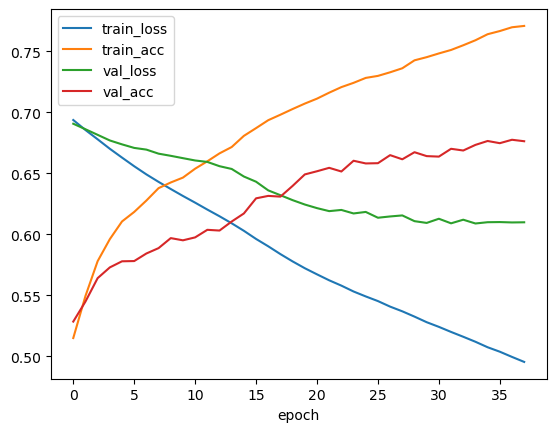

In [58]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()